In [1]:
import requests
from requests_futures.sessions import FuturesSession
import datetime as dt
import time
import sys
from drafterANN import *
import socket
import pickle

api_keys = ['FE70CE9FC0D6D99279498CE852587F59','2FEC67172AAC0C393EC209A225A7E51E']
api_key_num = 1
api_key = api_keys[api_key_num]
sleep_time = 7

drafter = DotoAnn()

leagues = ['4664']

i = 0
errors = 0

session = FuturesSession()

def next_matches(league_id):
    url = 'https://api.steampowered.com/IDOTA2Match_570/GetMatchHistory/V001/?key=' + api_key + '&league_id=' + league_id + '&start_at_match_id=' + str(next_id) + '&min_players=10'
    return session.get(url, timeout=4)

def next_match(match_id):
    url = 'https://api.steampowered.com/IDOTA2Match_570/GetMatchDetails/V001/?key=' + api_key + '&match_id=' + str(match_id)
    return session.get(url, timeout=4)

matches_bulk = list()

for league_id in leagues:
    next_id = ''
    req = next_matches(league_id)
    while True:
        try:
            try:
                r = req.result()
            except (requests.ConnectionError, requests.Timeout, socket.timeout):
                print("Unexpected error:", sys.exc_info()[0])
                errors += 1
                time.sleep(sleep_time)
                req = next_matches(league_id)
                continue

            if (r.status_code != 200):
                errors += 1
                time.sleep(sleep_time)
                req = next_matches(league_id)
                continue
            if 'matches' in r.json()['result']:
                matches = r.json()['result']['matches']
            else:
                time.sleep(sleep_time)
                req = next_matches(league_id)
                continue

            if len(matches) == 0:
                break

            next_id = matches[-1]['match_id'] - 1
            req = next_matches(league_id)

            for match in matches:
                m_req = next_match(match['match_id'])

                m = dict(id=match['match_id'])
                r_heroes = []
                d_heroes = []
                for player in match['players']:
                    if player['player_slot'] < 100:
                        r_heroes.append(str(player['hero_id']))
                    else:
                        d_heroes.append(str(player['hero_id']))
                m['radiant_heroes'] = ",".join(r_heroes)
                m['dire_heroes'] = ",".join(d_heroes)

                while True:
                    try:
                        m_res = m_req.result()
                    except (requests.ConnectionError, requests.Timeout, socket.timeout):
                        print("Unexpected error:", sys.exc_info()[0])
                        errors += 1
                        time.sleep(sleep_time)
                        m_req = next_match(match['match_id'])
                        continue
                    if (m_res.status_code != 200):
                        errors += 1
                        time.sleep(sleep_time)
                        m_req = next_match(match['match_id'])
                        continue
                    if 'radiant_win' in m_res.json()['result']:
                        rad_win = m_res.json()['result']['radiant_win']
                    else:
                        time.sleep(sleep_time)
                        m_req = next_match(match['match_id'])
                        continue
                    m['radiant_win'] = rad_win
                    break
                matches_bulk.append(m)
        except BaseException as e:
            print("Errors: ", errors)
            raise e

with open('data/league_matches.pickle','wb') as f:
    pickle.dump(matches_bulk,f)

In [3]:
from drafterANN import *
drafter = DotoAnn()

epoch_size = 3000
matches_bulk = list()

for m in Match.select().order_by(Match.seq_num.desc()).limit(epoch_size):
    match = {'radiant_heroes': m.radiant_heroes, 'dire_heroes': m.dire_heroes, 'radiant_win': m.radiant_win}
    matches_bulk.append(match)
    
print(len(matches_bulk))

3000


In [48]:
from drafterANN import *
import pickle

with open('data/league_matches.pickle','rb') as f:
     matches_bulk = pickle.load(f)
print(len(matches_bulk))

drafter = DotoAnn()
samples = []

def check_accuracy_for_mmr(mmr):
    ys = []
    for x in mmr:
        avg_certainty = 0
        correct_preds = 0
        
        batch_xs = np.zeros((len(matches_bulk), n_input), np.int)
        batch_ys = np.zeros((len(matches_bulk), n_out), np.int)
        for i,m in enumerate(matches_bulk):
            xs = np.zeros((1, n_input), np.int)
            for h in m['radiant_heroes'].split(","):
                xs[0][int(h)] = 1
            for h in m['dire_heroes'].split(","):
                xs[0][int(h) + max_heroes] = 1
            batch_xs[i] = xs
            outs = np.zeros((1, n_out), np.int)
            outs[0][not m['radiant_win']] = 1
            batch_ys[i] = outs
        out = drafter.run(batch_xs, x)
        
        i2=0
        for i, m in enumerate(out):
            certainty = abs(m[0] - 0.5)
            if (certainty > 0.0):
                avg_certainty += certainty
                correct_preds += np.argmax(m) == np.argmax(batch_ys[i])
                i2+=1
        print("Accuracy", correct_preds/i2)
        #print("Sample", i2)
        print("Avg Certainty", avg_certainty/i2 + 0.5)
        samples.append(i2)
        ys.append(correct_preds/i2)
    return ys


x = [1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000]
x = np.linspace(1000, 9000, num=20)
y = check_accuracy_for_mmr(x)

398
Accuracy 0.592964824121
Avg Certainty 0.608619130437


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:27: DeprecationWarning: using a boolean instead of an integer will result in an error in the future


Accuracy 0.597989949749
Avg Certainty 0.607410844987
Accuracy 0.597989949749
Avg Certainty 0.606316421718
Accuracy 0.592964824121
Avg Certainty 0.605369200322
Accuracy 0.590452261307
Avg Certainty 0.604514179128
Accuracy 0.595477386935
Avg Certainty 0.603739662459
Accuracy 0.590452261307
Avg Certainty 0.603021133664
Accuracy 0.587939698492
Avg Certainty 0.602362315886
Accuracy 0.58040201005
Avg Certainty 0.601813606766
Accuracy 0.577889447236
Avg Certainty 0.601358502757
Accuracy 0.587939698492
Avg Certainty 0.60094996262
Accuracy 0.590452261307
Avg Certainty 0.600727719356
Accuracy 0.597989949749
Avg Certainty 0.600639098031
Accuracy 0.600502512563
Avg Certainty 0.600608277941
Accuracy 0.600502512563
Avg Certainty 0.600653054457
Accuracy 0.597989949749
Avg Certainty 0.60074576019
Accuracy 0.595477386935
Avg Certainty 0.600936176112
Accuracy 0.590452261307
Avg Certainty 0.601204168532
Accuracy 0.587939698492
Avg Certainty 0.601673744663
Accuracy 0.582914572864
Avg Certainty 0.602296267

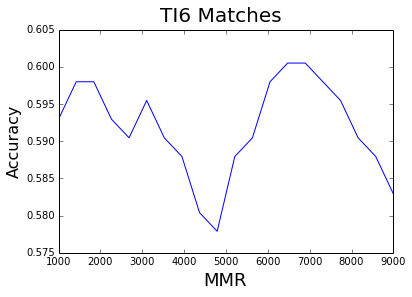

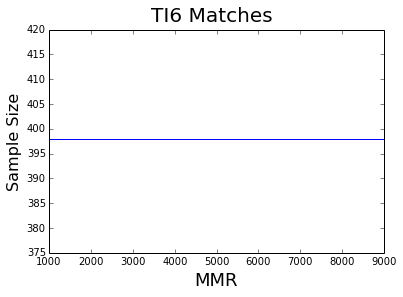

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.suptitle('TI6 Matches', fontsize=20)
plt.xlabel('MMR', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x,y)

fig = plt.figure()
fig.suptitle('TI6 Matches', fontsize=20)
plt.xlabel('MMR', fontsize=18)
plt.ylabel('Sample Size', fontsize=16)
plt.plot(x,samples)

In [54]:
from drafterANN import *
import pickle

with open('data/league_matches.pickle','rb') as f:
     matches_bulk = pickle.load(f)
print(len(matches_bulk))

drafter = DotoAnn()
samples = []

def check_accuracy_for_guess(guess):
    ys = []
    for x in guess:
        avg_certainty = 0
        correct_preds = 0
        
        batch_xs = np.zeros((len(matches_bulk), n_input), np.int)
        batch_ys = np.zeros((len(matches_bulk), n_out), np.int)
        for i,m in enumerate(matches_bulk):
            xs = np.zeros((1, n_input), np.int)
            for h in m['radiant_heroes'].split(","):
                xs[0][int(h)] = 1
            for h in m['dire_heroes'].split(","):
                xs[0][int(h) + max_heroes] = 1
            batch_xs[i] = xs
            outs = np.zeros((1, n_out), np.int)
            outs[0][not m['radiant_win']] = 1
            batch_ys[i] = outs
        out = drafter.run(batch_xs, 7500)
        
        i2=0
        for i, m in enumerate(out):
            certainty = abs(m[0] - 0.5)
            if (certainty > x - 0.5):
                avg_certainty += certainty
                correct_preds += np.argmax(m) == np.argmax(batch_ys[i])
                i2+=1
        #print("Certainty > ", x)
        #print("Sample", i2)
        samples.append(i2)
        if i2 > 0:
            #print("Accuracy", correct_preds/i2)
            #print("Avg Certainty", avg_certainty/i2 + 0.5)
            ys.append(correct_preds/i2)
        else:
            ys.append(1)
    return ys

x = np.linspace(0.5, 0.9, num=30)
y = check_accuracy_for_guess(x)

398


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:27: DeprecationWarning: using a boolean instead of an integer will result in an error in the future


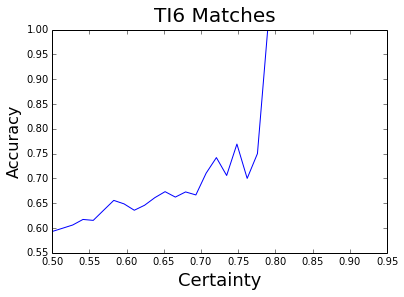

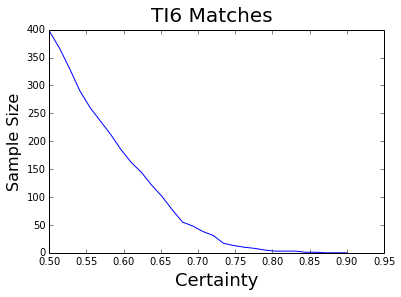

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.suptitle('TI6 Matches', fontsize=20)
plt.xlabel('Certainty', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x,y)

fig = plt.figure()
fig.suptitle('TI6 Matches', fontsize=20)
plt.xlabel('Certainty', fontsize=18)
plt.ylabel('Sample Size', fontsize=16)
plt.plot(x,samples)